In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from src.data.importer import *
from src.data.processer import *
from src.events.main import sim_events, list_of_params
from src.probability.functions import ic_params_nsi,perform_chisq
from scipy.stats import chi2
from src.events.event_processing import *
import pickle
from multiprocessing import Pool
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)

giunti_contour_cl90 = pd.read_csv('./src/data/files/giunti_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl90 = pd.read_csv('./src/data/files/ic_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
giunti_contour_cl99 = pd.read_csv('./src/data/files/giunti_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl99 = pd.read_csv('./src/data/files/ic_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
ic_34_cl90 = pd.read_csv('./src/data/files/ic_34_cl90.csv',header=None, names=['s24','s34']).sort_values('s34')
ic_34_cl99 = pd.read_csv('./src/data/files/ic_34_cl99.csv',header=None, names=['s24','s34']).sort_values('s34')


C:\Users\Martin\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [24]:
ndim = 4
N = 13
alpha = 0.99
precomputed_events = True
gamma=0
ic_params_nsi['dm_41'] = 0.93
ic_params['dm_41'] = 0.93
emm_range = np.linspace(-1e-1,1e-1,10)
s24_range = np.logspace(-2,np.log10(0.2),10)
emt_range = np.linspace(-1e-2,1e-2,10)
param_list = list_of_params_nsi(ic_params_nsi,s24_range, emm_range,emt_range)

#for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
#    assert is_precomputed_nsi(N=N,ndim=ndim, dict=p,check=False)


'''
param_list = return_precomputed_nsi(N,ndim,params=param_list)
emm_range = np.sort(np.unique(np.array([p['e_mm'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2
emt_range = np.sort(np.unique(np.array([p['e_mt'] for p in param_list])))

print(emm_range)
print(s24_range)
print(emt_range)
'''

"\nparam_list = return_precomputed_nsi(N,ndim,params=param_list)\nemm_range = np.sort(np.unique(np.array([p['e_mm'] for p in param_list])))\ns24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2\nemt_range = np.sort(np.unique(np.array([p['e_mt'] for p in param_list])))\n\nprint(emm_range)\nprint(s24_range)\nprint(emt_range)\n"

In [25]:
if not precomputed_events:
    print('Computing events')
    from multiprocessing import Pool
    p = Pool()
    data = [(alpha, N,p, False,False, [False, np.median(Ereco), gamma],True, True) for p in param_list]
    H1_events_list = p.starmap(sim_events, data)
    p.close()
    if len(emt_range) > 1:
        pickle.dump(H1_events_list,open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi.p','wb'))
    else:
        pickle.dump(H1_events_list,open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}_tau_nsi.p','wb'))

    H0_events = sim_events(alpha=alpha,npoints=N,params=ic_params, null=True, multi=False, spectral_shift=[False, np.median(Ereco), gamma],tau=True, nsi=True)
    pickle.dump(H0_events,open(f'./pre_computed/H0_N{N}_nsi_emt.p','wb'))
'''
if len(emt_range) > 1:
    H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi.p','rb'))
else:
    H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}_tau_nsi.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_N{N}_nsi.p','rb'))

'''
H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi_bigemm.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_N{N}_nsi.p','rb'))

gamma = 0.3
delta_T = (np.sum(sim_events(alpha=alpha,npoints=N,params=ic_params, null=True, multi=False, spectral_shift=[True, np.median(Ereco), gamma],tau=True, nsi=True)) - np.sum(H0_events))/np.sum(H0_events)

H0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,z_bins)

In [26]:
sigma_a = 0.25
sigma_b = 0.04
f = 0.1
deltachi, best_index, H1_chisq,H0_chisq = get_deltachi(H1_list_normalized, H0_normalized,emm_range,s24_range,delta_T,[sigma_a,sigma_b],f,x0=[1],z_range=emt_range)
best_emt_index, best_emm_index, best_s24_index = np.unravel_index(np.argmin(deltachi),deltachi.shape)
best_emt, best_emm, best_s24 = emt_range[best_emt_index], emm_range[best_emm_index], s24_range[best_s24_index]

In [27]:
param_list[best_index] #(s24,emm,emt)

{'theta_12': 0.5837630475986898,
 'theta_13': 0.15494769630192953,
 'theta_23': 0.7695841386786632,
 'theta_34': 0,
 'theta_24': 0.0500837105807799,
 'theta_14': 0,
 'delta_ij': 3.4033920413889422,
 'dm_21': 7.53e-05,
 'dm_31': 0.0025153,
 'dm_41': 0.93,
 'e_ee': 0,
 'e_me': 0,
 'e_et': 0,
 'e_mm': 0.1,
 'e_mt': 0.0011111111111111113,
 'e_tt': 0,
 'e_es': 0,
 'e_ms': 0,
 'e_ts': 0,
 'e_ss': 0}

In [30]:
np.swapaxes(deltachi,0,2)[4] #np.swapaxes(deltachi,0,2)[best_s24_index] 

array([[ 9.72679371,  8.73797115,  8.06395806,  7.70700925,  7.51655358,  7.5875095 ,  7.78873262,  8.28835037,  9.0730013 , 10.23716572],
       [ 9.27657198,  8.20926049,  7.4800784 ,  7.09705833,  6.91401895,  6.98165252,  7.21220777,  7.72145312,  8.56091952,  9.83804019],
       [ 8.77621187,  7.65019203,  6.89344427,  6.51100278,  6.32674676,  6.38558651,  6.62572912,  7.14690606,  8.01507176,  9.36998521],
       [ 8.22791131,  7.07533226,  6.3223287 ,  5.92795898,  5.75052055,  5.79753435,  6.04256639,  6.56670353,  7.43166791,  8.84055336],
       [ 7.61221774,  6.46961601,  5.73726383,  5.3571937 ,  5.18158976,  5.21842083,  5.45748553,  5.97015518,  6.8223959 ,  8.22110282],
       [ 6.95111796,  5.84733357,  5.1580015 ,  4.79578635,  4.61897406,  4.65747106,  4.88363061,  5.36633168,  6.17843707,  7.52383216],
       [ 6.22580979,  5.20120307,  4.56825973,  4.22213492,  4.06489027,  4.09113026,  4.31193554,  4.75299905,  5.50185124,  6.75226829],
       [ 5.46227694,  4.542

In [31]:
emt_cl90, emt_cl99, emm_cl90, emm_cl99= get_contour(np.swapaxes(deltachi,0,2)[4], emm_range,emt_range,2)

In [36]:
np.where(np.swapaxes(deltachi,0,2)[3] < chi2.ppf(q = 0.90,df=2),True,False)

array([[False, False, False,  True,  True,  True,  True, False, False, False],
       [False, False,  True,  True,  True,  True,  True,  True, False, False],
       [False,  True,  True,  True,  True,  True,  True,  True, False, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [37]:
emt_cl90_index_1 = [5,2,1,0,0,0,0,1,3,6]
emt_cl90_index_2 = [9]*10

In [38]:
emt_range[emt_cl90_index_1], emt_range[emt_cl90_index_2] # -1.1e-2< emt < 1.1e-2

(array([ 0.00111111, -0.00555556, -0.00777778, -0.01      , -0.01      , -0.01      , -0.01      , -0.00777778, -0.00333333,  0.00333333]),
 array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]))

Text(0.05, 0.65, '$\\pi_N = 0.25$\n$\\pi_\\theta = 0.04$\n$\\Delta \\gamma = 0.3$\n$f = 0.1$\n')

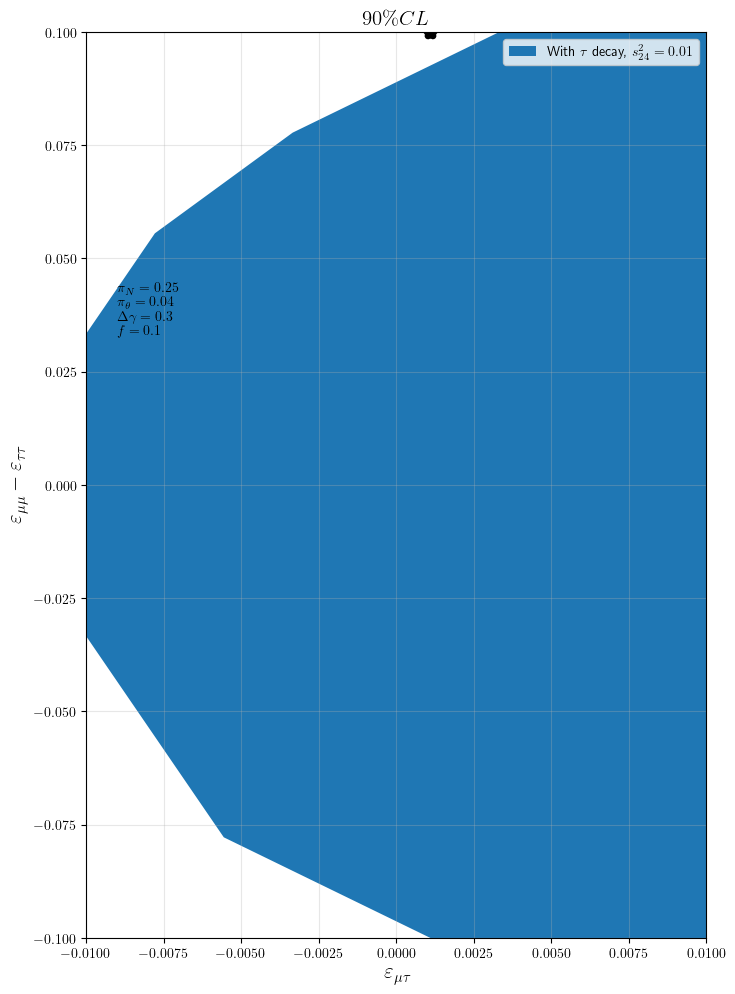

In [39]:
fig,ax = plt.subplots(1,1,figsize=(8,12))


ax.fill_betweenx(emm_cl90,emt_range[emt_cl90_index_1], emt_range[emt_cl90_index_2], label=rf'With $\tau$ decay, $s_{{24}}^2={np.round(best_s24,3)}$ ')
ax.scatter(best_emt, best_emm, marker='*',c='black',lw=5)

#ax[1].plot(emt_cl99, emt_cl99, label=r'With $\tau$ decay, $s_{34}^2=0$ ')


ax.set_xlim((emt_range.min(), emt_range.max()))
#ax[1].set_xlim((emt_range.min(), emt_range.max()))
ax.set_ylim((emm_range.min(),emm_range.max()))
#ax[1].set_ylim((emm_range.min(),emm_range.max()))
ax.set_xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=15)
#ax[1].set_xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=15)
ax.set_ylabel(r'$\varepsilon_{\mu\mu} - \varepsilon_{\tau\tau}$', fontsize=15)
ax.grid(True, which='both', alpha=0.3)
#ax[1].grid(True, which='both', alpha=0.3)
ax.set_title(r'$90\% CL$', fontsize=15)
#ax[1].set_title(r'$99\% CL$', fontsize=15)

ax.legend()
#ax[1].legend()
plt.annotate(f'$\pi_N = {sigma_a}$\n$\pi_\\theta = {sigma_b}$\n$\Delta \gamma = {gamma}$\n$f = {f}$\n', 
        xy=(0.05, 0.65), xycoords='axes fraction')
#plt.plot(best_fit_coords[0], best_fit_coords[1], marker='o', color='black')

In [24]:
# Plots for Smirnov 2013
from plotter import P_over_E_parameter
ic_params_nsi['dm_41'] = 0.93
plot_params = list_of_params_nsi(ic_params_nsi, emm_range= np.array([-0.1,0,0.1]), s24_range=np.array([0.1]))
Pam = P_over_E_parameter('m', param_dict_list=plot_params, E=np.logspace(3,4,50), zenith = -1, ndim = 4, anti=True, nsi=True)
Pm = P_over_E_parameter('m', param_dict_list=plot_params, E=np.logspace(3,4,50), zenith =-1, ndim = 4, anti=False, nsi=True)
Pe = P_over_E_parameter('e', param_dict_list=plot_params, E=np.logspace(3,4,50), zenith = -1, ndim = 4, anti=False, nsi=True)
Pae = P_over_E_parameter('e', param_dict_list=plot_params, E=np.logspace(3,4,50), zenith = -1, ndim = 4, anti=True, nsi=True)

Pamam = Pam[:,1]
Pamat = Pam[:,2]
Pmm = Pm[:,1]
Pmt = Pm[:,2]
Pem = Pe[:,1]
Paeam = Pae[:,1]

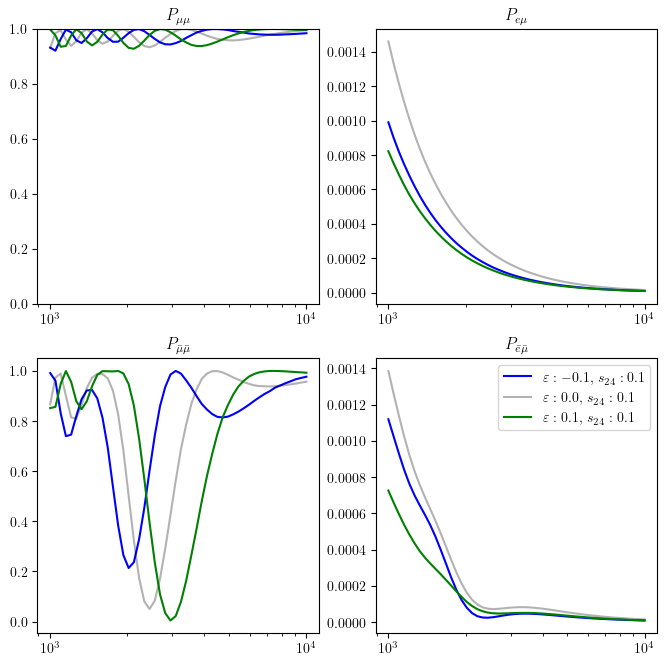

In [25]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax = ax.flatten()
colors = ['blue','black','green']
alpha = [1,0.3,1]
for i,prob in enumerate(Pmm):
    ax[0].plot(np.logspace(3,4,50), prob, c=colors[i], alpha=alpha[i],label=f'$\\varepsilon: {np.round(plot_params[i]["e_mm"],2)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')

for i,prob in enumerate(Pmt):
    ax[1].plot(np.logspace(3,4,50), prob, c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mm"],2)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')
for i,prob in enumerate(Pamam):
    ax[2].plot(np.logspace(3,4,50), prob,c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mm"],2)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')
for i,prob in enumerate(Pamat):
    ax[3].plot(np.logspace(3,4,50), prob,c=colors[i],alpha=alpha[i], label=f'$\\varepsilon: {np.round(plot_params[i]["e_mm"],2)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$')

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].set_ylim((0,1))
ax[0].set_title('$P_{\mu\mu}$')
ax[1].set_title('$P_{e\mu}$')
ax[2].set_title('$P_{\\bar{\mu}\\bar{\mu}}$')
ax[3].set_title('$P_{\\bar{e}\\bar{\mu}}$')
plt.legend()